# Applying Convolutional Neural Networks for detection of distorted mortality rates due to errors and migration in population data

## Abstract
Convolutional Neural Networks (CNNs) are typically applied on image and video data for classification problems. A famous CNN winning the ImageNet Recognition Challenge is for example [AlexNet](https://en.wikipedia.org/wiki/AlexNet), an 8-layer CNN for image classification. CNNs are also frequently applied in Computer Vision for object detection (existence and location) in images.
This notebook shows how a simple 4-layer CNN (not counting the batch normalizations separately) can help to detect distortions of mortality rates (which can be considered as a 2D image with dimensions age and year and color channels for males, females, females less males, analogous to red, green, blue) due to errors and migration in population data.

## Introduction
Mortality rates $q_{x,t}$ by country and sex, i.e. the probably of dying at age $x$ (last birthday) between year $t$ and $t+1$, are derived from population numbers/exposures $E_{x,t}$ at given points in time $t$, e.g. from census data every 5 years, and death counts $D_{x,t}$, which typically are available at much better time resolution. Both $E_{x,t}$ and $D_{x,t}$ can be affected by errors and migration, which distorts mortality rates $q_{x,t}=D_{x,t}/E_{x,t}$.

A way to measure this potential distortion is by considering normalized residuals $r_{x,t}$ defined as

$$r_{x,t} = \frac{E_{x,t}-E_{x-1,t-1}(1-q_{x-1,t-1})}{E_{x,t}}$$

i.e. by comparing the actual population numbers/exposures $E_{x,t}$ to the one derived from the previous year $E_{x-1,t-1}(1-q_{x-1,t-1})$. A value $r_{x,t}>0$ indicates immigration or an error. A value $r_{x,t}<0$ indicates emigration or an error.

This notebook applies a Computer Vision approach to all mortality rates available from the [Human Mortality Database](https://www.mortality.org/), where inputs $X$ are moving windows of size **nx=10** times **nt=10** and stepsize **sx=5** and **st=5** of (logit of) mortality rates $q_{x,t}$ for both sexes (males, females and the difference between females and males are used as channels, analogous to red/green/blue for color images), i.e. $X\in\mathbb{R}^{\text{#windows}\times 10\times 10\times 3}$ and outputs $Y\in\mathbb{R}^{\text{#windows}}$ are maximum absolute values of $r_{x,t}$ over the same moving windows. Whenever the maxima of a given window exceeds the 95% quantile of maxima over all windows, we define that error/migration might be present in the given window.

The trained CNN can then be used to detect areas/windows of $q_{x,t}$, where errors and migration potentially distorted mortality rates.

The used CNN is a simple 3-layer network comprising
* a convolutional 2D layer: 16 filters of size 3 times 3 and stepsize 1 and 1, 3 channels for logit mortality rates of males, females and females less males,
* a convolutional 2D layer: 32 filters of size 3 times 3 and stepsize 1 and 1, 3 channels,
* a convolutional 2D layer: 64 filters of size 3 times 3 and stepsize 1 and 1, 3 channels,
* a fully connected layer.

We first formulate the problem as a regression problem minimizing mean square errors, i.e. we would like to predict the size of errors and migration. Then, in order to assess the quality of resulting classifications we use area under curve (AUC).
1. First, we train CNNs on each population separately (with a simpler CNN) and for each trained population we predict errors/migration for all populations. This results in an AUC matrix, that reveals that the error/migration structure can be quite different between various populations.
2. We derive a clustering from the calculated AUC matrix to focus on populations with similar error/migration structures.
3. On the largest cluster of step 2. we then train a CNN on 85% of the data (which is further split into 85% train and 15% validation) and use the remaining 15% as test set to come up with a final AUC and a visual comparison between actual output $Y$ and predictions $P$.

## 0-0. Import modules, definition of parameters, handle missing values
Required modules are
* pandas -  for reading text files,
* matplotlib - for plots,
* sklearn - for ROC curves,
* scipy - for clustering countries by similarities in error/migration structure (for steps 1. and 2.),
* keras - for CNN.

For missing/invalid values in both population data and mortality rates a simple 2D linear interpolation and nearest value for corner cases is used.

In [13]:
# Notebook settings
###################

# resetting variables
get_ipython().magic('reset -sf')

# formatting: cell width
from IPython.core.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

# plotting
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
import scipy as sp
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Activation
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score, consensus_score
from sklearn.datasets import make_biclusters
from sklearn.cluster import SpectralCoclustering, SpectralBiclustering

pops = ['CAN', 'AUS',#'AUT','BEL','BGR','BLR','CAN','CHE','CHL','CZE',
        #'DEU','DNK','ESP','EST','FIN','FRA','GBR','GRC','HKG',
        #'HRV','HUN','IRL','ISL','ISR','ITA','JPN','KOR','LTU',
        #'LUX','LVA','NLD','NOR','NZL','POL','PRT','RUS','SVK',
        'USA']#'SVN','SWE','TWN','UKR','USA']
testPop = 'ABC' # population to test how a 'flat' input X without any signal about migration/error is handled
nx = 10 # window size in terms of ages
nt = 10 # window size in terms of years
sx = 5 # step width of windows in terms of ages
st = 5 # step width of windows in terms of years
minAge = 21
maxAge = 80
cutoffYear = 1951 # ignore years before 1951 because of some countries having exposures of civilians only
testRatio = 0.15
validationRatio = 0.15
thresholdQ = 0.95 # defines migration/error in terms of a quantile threshold
filterSize = 5
numberFilters = 16
filterSize1 = 3
numberFilters1 = 16
filterSize2 = 3
numberFilters2 = 32
filterSize3 = 3
numberFilters3 = 64
numberEpochs = 800
qxm = dict.fromkeys(pops)
qxf = dict.fromkeys(pops)
exm = dict.fromkeys(pops)
exf = dict.fromkeys(pops)
rxm = dict.fromkeys(pops)
rxf = dict.fromkeys(pops)
X = dict.fromkeys(pops)
Y = dict.fromkeys(pops)
ageBuckets = dict.fromkeys(pops)
yearBuckets = dict.fromkeys(pops)
plt.rcParams.update({'figure.max_open_warning': 0})

def fillMissingValues(v):
    x, y = np.meshgrid(np.arange(v.shape[1]), np.arange(v.shape[0]))
    v = np.ma.masked_invalid(v)
    v = sp.interpolate.griddata((x[~v.mask], y[~v.mask]), v[~v.mask], (x, y), method='linear')
    v = np.ma.masked_invalid(v)
    return sp.interpolate.griddata((x[~v.mask], y[~v.mask]), v[~v.mask], (x, y), method='nearest')

## 0-1. Data loading, cleaning, setting up input/predictors X and output/target Y
The Human Mortality Database provides the required population numbers/exposure $E_{x,t}$ and mortality rates $q_{x,t}$ as structured text files that can easily be read by the pandas module. However, some cases require some data cleaning, i.e.
* treatment of age '110+' that gathers ages above 109,
* some missing mortality rates,
* population numbers/exposure given as two values in case of territorial changes, e.g. 1959- and 1959+.

Overall, the structures of normalized residuals $r_{x,t}$ vary quite a lot across all populations. Note the different 'wave' structures of Japan (along year axis), USA (along age axis), and Russia (along cohorts/diagonals) for example.

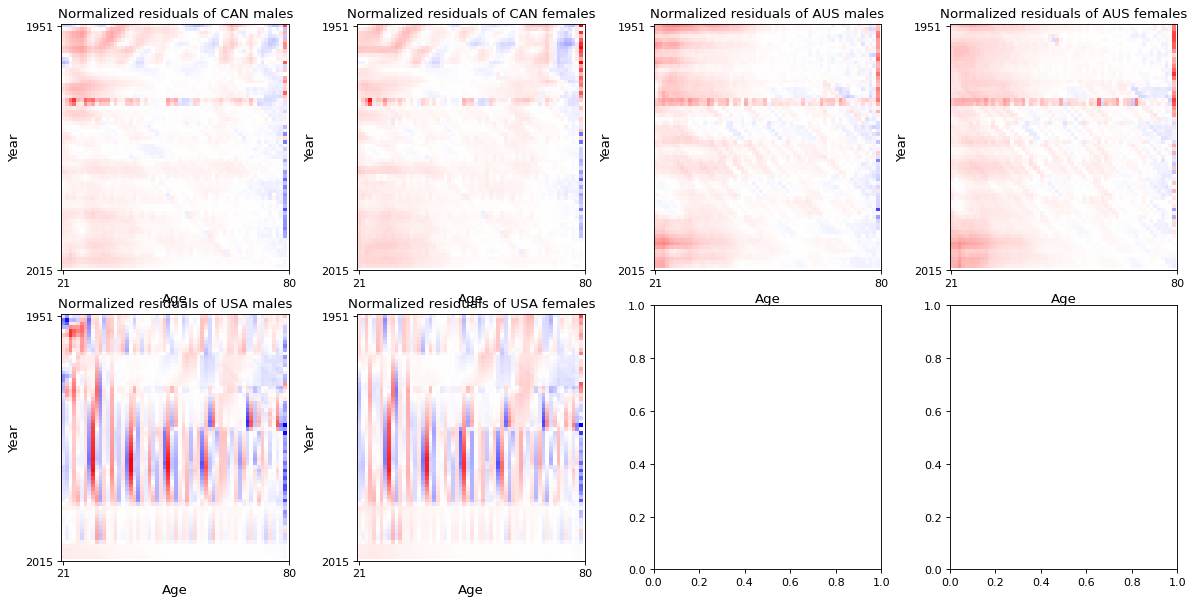

<Figure size 1440x1120 with 0 Axes>

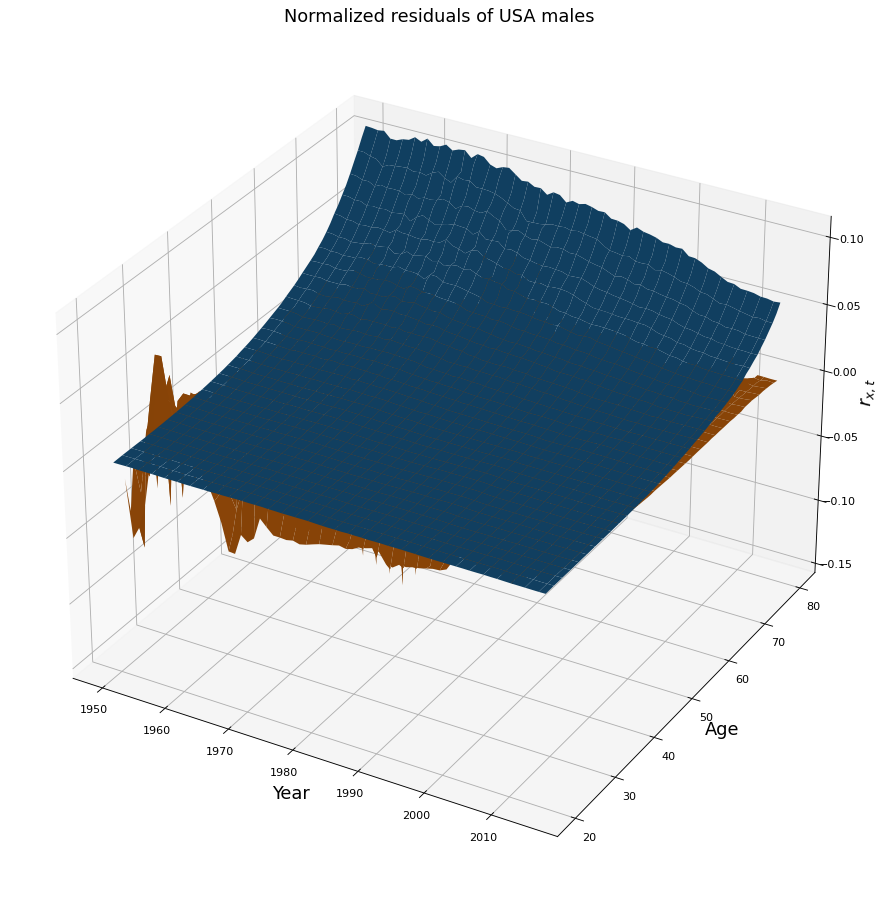

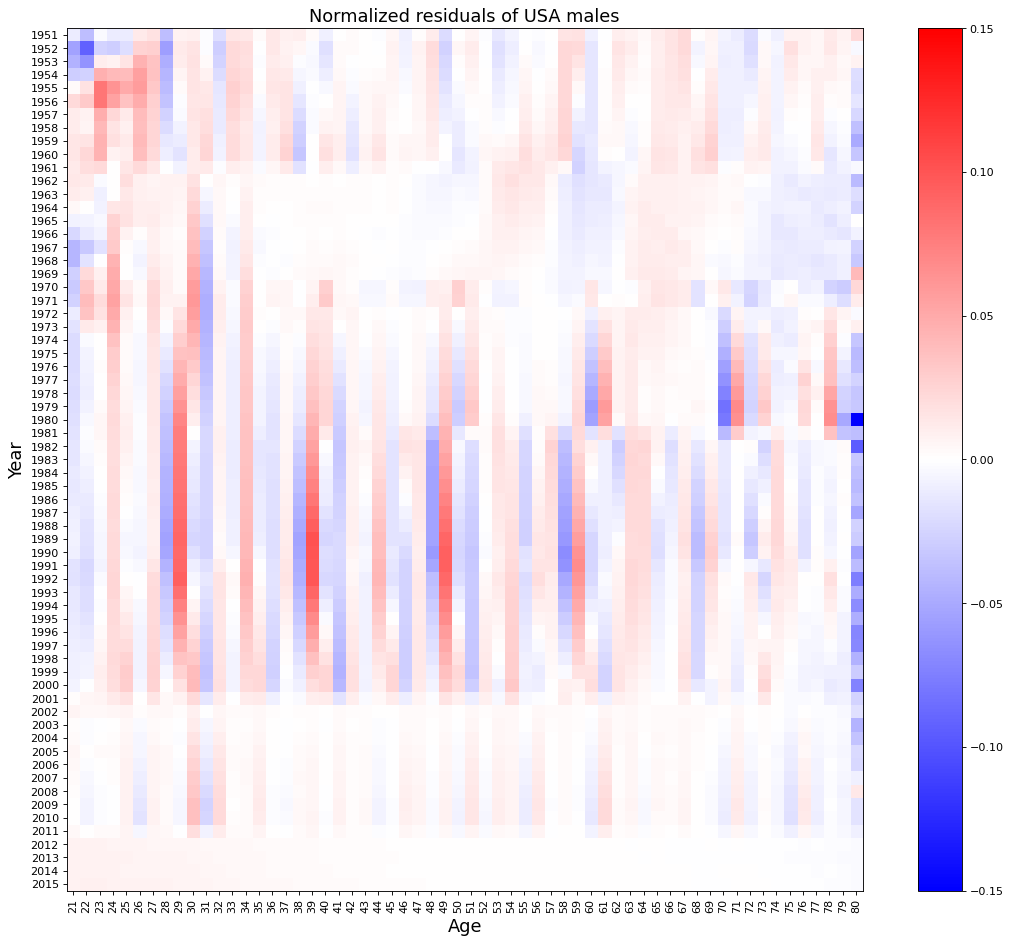

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D # Import the Axes3D class

subfig, subax = plt.subplots(int(np.ceil(2*len(pops)/4)), 4, figsize=(18,len(pops)*3), dpi=80)
subfig.subplots_adjust(hspace = .1, wspace=.3)
subax = subax.ravel()
for jPop in range(len(pops)):
    pop = pops[jPop]
    df = pd.read_csv('data/' + pop + '_M.txt', delim_whitespace=True, header=1)
    minYear = max(cutoffYear, int(np.ceil(df.Year.min()/5)*5)+1)
    maxYear = int(np.floor(df.Year.max()/5)*5)
    df = df[(df.Age!='110+')]
    df.Age = pd.to_numeric(df.Age)
    df = df[(df.Age>=minAge-1) & (df.Age<=maxAge) & (df.Year>=minYear-1) & (df.Year<=maxYear)]
    nAge = df.Age.nunique()
    nYear = df.shape[0]//nAge
    year = df.Year.values.reshape(nYear, nAge)
    age = df.Age.astype(float).values.reshape(nYear, nAge)
    if is_string_dtype(df.qx):
        df.qx = pd.to_numeric(df.qx, errors='coerce')
    qxm[pop] = df.qx.values.reshape(nYear, nAge)

    df = pd.read_csv('data/' + pop + '_F.txt', delim_whitespace=True, header=1)
    df = df[(df.Age!='110+')]
    df.Age = pd.to_numeric(df.Age)
    df = df[(df.Age>=minAge-1) & (df.Age<=maxAge) & (df.Year>=minYear-1) & (df.Year<=maxYear)]
    year = df.Year.values.reshape(nYear, nAge)
    age = df.Age.astype(float).values.reshape(nYear, nAge)
    if is_string_dtype(df.qx):
        df.qx = pd.to_numeric(df.qx, errors='coerce')
    qxf[pop] = df.qx.values.reshape(nYear, nAge)

    if pop in ['GBR']:
        fig = plt.figure(figsize=(18,14), dpi=80)
        ax = fig.gca(projection='3d')
        ax.plot_surface(year, age, qxm[pop])
        ax.set_xlabel('Year', fontsize=16)
        ax.set_ylabel('Age', fontsize=16)
        ax.set_zlabel('$q_x$', fontsize=16)
        ax.set_title('Mortality rates of ' + pop + ' males', fontsize=16)

        fig = plt.figure(figsize=(18,14), dpi=80)
        ax = fig.gca(projection='3d')
        ax.plot_surface(year, age, np.log(qxm[pop]/(1-qxm[pop])))
        ax.set_xlabel('Year', fontsize=16)
        ax.set_ylabel('Age', fontsize=16)
        ax.set_zlabel('$q_x$', fontsize=16)
        ax.set_title('logit mortality rates of ' + pop + ' males', fontsize=16)

    df = pd.read_csv('data/' + pop + '.txt', delim_whitespace=True, header=1)
    df = df[(df.Age!='110+')]
    df.Age = pd.to_numeric(df.Age)
    df = df[(df.Age>=minAge-1) & (df.Age<=maxAge)]
    if is_string_dtype(df.Male):
        df.Male = pd.to_numeric(df.Male, errors='coerce')
    if is_string_dtype(df.Female):
        df.Female = pd.to_numeric(df.Female, errors='coerce')
    if is_string_dtype(df.Year):
        df.Year = df.Year.str[:4] # handle e.g. 1959+, 1959- cases
        df = df.groupby(['Year','Age'], as_index=False).mean()
        df.Year = pd.to_numeric(df.Year)
        df = df.sort_values(['Year', 'Age'], ascending=[1,1])
    df = df[(df.Year>=minYear-1) & (df.Year<=maxYear)]
    year = df.Year.values.reshape(nYear, nAge)
    age = df.Age.values.reshape(nYear, nAge)
    exm[pop] = df.Male.values.reshape(nYear, nAge)
    exf[pop] = df.Female.values.reshape(nYear, nAge)

    if pop in ['GBR']:
        fig = plt.figure(figsize=(18,14), dpi=80)
        ax = fig.gca(projection='3d')
        ax.plot_surface(year, age, exm[pop])
        ax.set_xlabel('Year', fontsize=16)
        ax.set_ylabel('Age', fontsize=16)
        ax.set_zlabel('$e_x$', fontsize=16)
        ax.view_init(elev=10., azim=230)
        ax.set_title('Population numbers/exposures of ' + pop + ' males', fontsize=16)

        plt.figure(figsize=(18,14), dpi=80)
        plt.imshow(exm[pop], cmap='magma')
        plt.title('Population numbers/exposures of ' + pop + ' males', fontsize=16)
        plt.xticks(np.arange(maxAge-minAge+2), np.arange(minAge-1, maxAge+1, 1), rotation=90)
        plt.yticks(np.arange(maxYear-minYear+2), np.arange(minYear-1, maxYear+1, 1))
        plt.xlabel('Age', fontsize=16)
        plt.ylabel('Year', fontsize=16)
        plt.colorbar()

    exmd = exm[pop]*(1-qxm[pop])
    exmd = np.concatenate((np.zeros([1,exmd.shape[1]]), exmd), axis=0)
    exmd = np.concatenate((np.zeros([exmd.shape[0],1]), exmd), axis=1)
    exme = exm[pop]
    exme = np.concatenate((exme, np.zeros([1,exme.shape[1]])), axis=0)
    exme = np.concatenate((exme, np.zeros([exme.shape[0],1])), axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        rxm[pop] = (exme-exmd)/exme
    rxm[pop] = rxm[pop][1:-1,1:-1]
    exfd = exf[pop]*(1-qxf[pop])
    exfd = np.concatenate((np.zeros([1,exfd.shape[1]]), exfd), axis=0)
    exfd = np.concatenate((np.zeros([exfd.shape[0],1]), exfd), axis=1)
    exfe = exf[pop]
    exfe = np.concatenate((exfe, np.zeros([1,exfe.shape[1]])), axis=0)
    exfe = np.concatenate((exfe, np.zeros([exfe.shape[0],1])), axis=1)
    with np.errstate(divide='ignore', invalid='ignore'):
        rxf[pop] = (exfe-exfd)/exfe
    rxf[pop] = rxf[pop][1:-1,1:-1]
    rxf[pop] = fillMissingValues(rxf[pop])
    rxm[pop] = fillMissingValues(rxm[pop])

    if pop in ['GBR','JPN','RUS','USA']:
        fig = plt.figure(figsize=(18,14), dpi=80)
        fig = plt.figure(figsize=(18,14), dpi=80)
        ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot
        ax.plot_surface(year, age, qxm[pop])
        ax.plot_surface(year[1:,1:], age[1:,1:], rxm[pop])
        ax.set_xlabel('Year', fontsize=16)
        ax.set_ylabel('Age', fontsize=16)
        ax.set_zlabel('$r_{x,t}$', fontsize=16)
        ax.set_title('Normalized residuals of ' + pop + ' males', fontsize=16)

        fig = plt.figure(figsize=(18,14), dpi=80)
        plt.imshow(rxm[pop], cmap='bwr', vmin=-0.15, vmax=0.15)
        plt.title('Normalized residuals of ' + pop + ' males', fontsize=16)
        plt.xticks(np.arange(maxAge-minAge+1), np.arange(minAge, maxAge+1, 1), rotation= 90)
        plt.yticks(np.arange(maxYear-minYear+1), np.arange(minYear, maxYear+1, 1))
        plt.xlabel('Age', fontsize=16)
        plt.ylabel('Year', fontsize=16)
        plt.colorbar()

    subax[2*jPop].imshow(rxm[pop], cmap='bwr', vmin=-0.1, vmax=0.1)
    subax[2*jPop].set_title('Normalized residuals of ' + pop + ' males', fontsize=12)
    subax[2*jPop].set_xticks(np.array([0,maxAge-minAge+1]))
    subax[2*jPop].set_xticklabels(np.array([minAge, maxAge]))
    subax[2*jPop].set_yticks(np.array([0,maxYear-minYear+1]))
    subax[2*jPop].set_yticklabels(np.array([minYear, maxYear]))
    subax[2*jPop].set_xlabel('Age', fontsize=12)
    subax[2*jPop].set_ylabel('Year', fontsize=12)
    subax[2*jPop+1].imshow(rxf[pop], cmap='bwr', vmin=-0.1, vmax=0.1)
    subax[2*jPop+1].set_title('Normalized residuals of ' + pop + ' females', fontsize=12)
    subax[2*jPop+1].set_xticks(np.array([0,maxAge-minAge+1]))
    subax[2*jPop+1].set_xticklabels(np.array([minAge, maxAge]))
    subax[2*jPop+1].set_yticks(np.array([0,maxYear-minYear+1]))
    subax[2*jPop+1].set_yticklabels(np.array([minYear, maxYear]))
    subax[2*jPop+1].set_xlabel('Age', fontsize=12)
    subax[2*jPop+1].set_ylabel('Year', fontsize=12)

    mx = int(np.floor((maxAge-minAge+1-nx)/sx+1))
    mt = int(np.floor((rxm[pop].shape[0]-nt)/st+1))
    ageBuckets[pop] = np.array(range(mx))*sx+np.floor(nx/2)+minAge
    yearBuckets[pop] = np.array(range(mt))*st+np.floor(nt/2)+minYear
    X[pop] = np.zeros([mx*mt,nx,nt,3])
    Y[pop] = np.zeros(mx*mt)
    with np.errstate(divide='ignore'):
        lqxm = np.log(qxm[pop][1:,1:]/(1-qxm[pop][1:,1:])) # remove first year/first age just like for rxm
        lqxf = np.log(qxf[pop][1:,1:]/(1-qxf[pop][1:,1:]))
    lqxm = fillMissingValues(lqxm)
    lqxf = fillMissingValues(lqxf)

    if pop==testPop: # use testPop as a population with flat input X
        lqxm[:,:]=-5
        lqxf[:,:]=-5

    for j in range(mx):
        for k in range(mt):
            # set up logit qx windows of size nt x nx for each population as input X (population x year buckets x age buckets x sex)
            X[pop][k*mx+j,:,:,0] = lqxm[k*st:k*st+nt,j*sx:j*sx+nx] # logit qx of males as first channel
            X[pop][k*mx+j,:,:,1] = lqxf[k*st:k*st+nt,j*sx:j*sx+nx] # logit qx of females as second channel
            X[pop][k*mx+j,:,:,2] = X[pop][k*mx+j,:,:,1] - X[pop][k*mx+j,:,:,0] # logit qx of females less males as third channel
            # define output Y as the maximum absolute value of normalized residuals over each window of size nt x nx
            Y[pop][k*mx+j] = np.max(0.5*np.abs(rxm[pop][k*st:k*st+nt,j*sx:j*sx+nx]+rxf[pop][k*st:k*st+nt,j*sx:j*sx+nx]))

## 0-2. Normalize input/predictors X and output/target Y into [0,1] interval

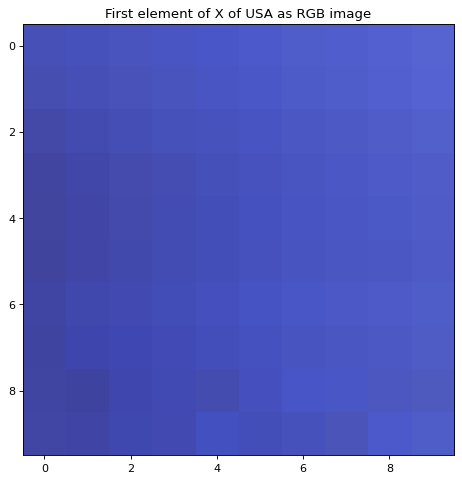

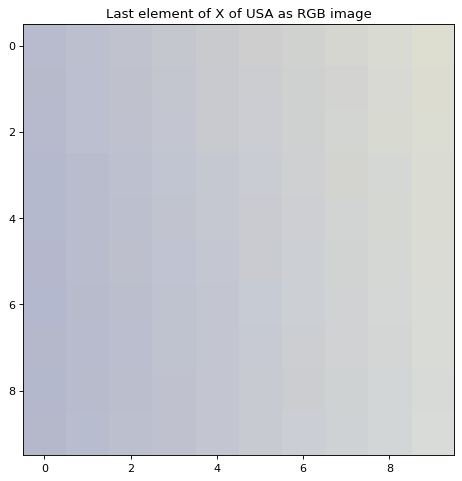

In [15]:
# normalize X, Y
minX0 = np.min([np.min(k[:,:,:,0]) for k in X.values()])
maxX0 = np.max([np.max(k[:,:,:,0]) for k in X.values()])
minX1 = np.min([np.min(k[:,:,:,1]) for k in X.values()])
maxX1 = np.max([np.max(k[:,:,:,1]) for k in X.values()])
minX2 = np.min([np.min(k[:,:,:,2]) for k in X.values()])
maxX2 = np.max([np.max(k[:,:,:,2]) for k in X.values()])
minY = np.min([np.min(k) for k in Y.values()])
maxY = np.max([np.max(k) for k in Y.values()])
for pop in pops:
    X[pop][:,:,:,0] = (X[pop][:,:,:,0]-minX0)/(maxX0-minX0)
    X[pop][:,:,:,1] = (X[pop][:,:,:,1]-minX1)/(maxX1-minX1)
    X[pop][:,:,:,2] = (X[pop][:,:,:,2]-minX2)/(maxX2-minX2)
    Y[pop] = (Y[pop]-minY)/(maxY-minY)

plt.figure(figsize=(9,7), dpi=80)
plt.imshow(X['USA'][1,:,:,:])
plt.title('First element of X of USA as RGB image')
plt.figure(figsize=(9,7), dpi=80)
plt.imshow(X['USA'][-1,:,:,:])
plt.title('Last element of X of USA as RGB image');

## 1. Setup and train CNN sequentially on each population to derive AUC matrix

5/5 [==============================] - 0s 10ms/step


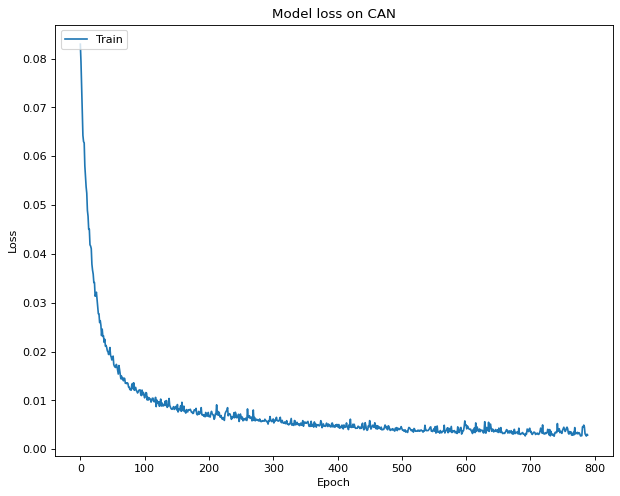

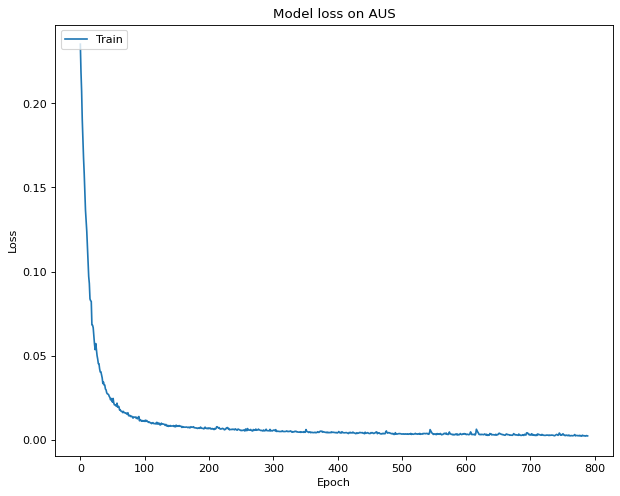

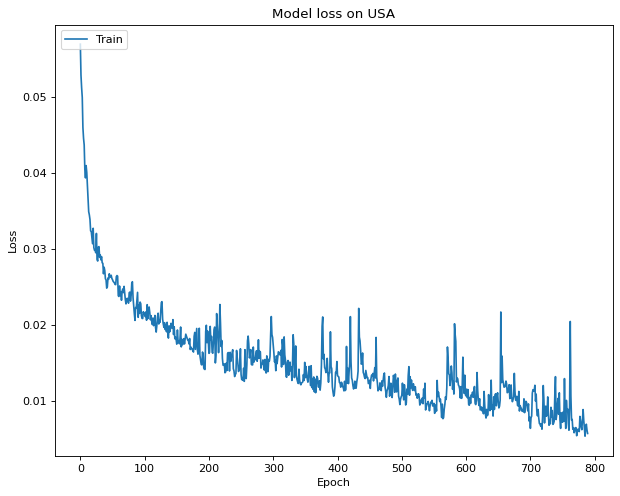

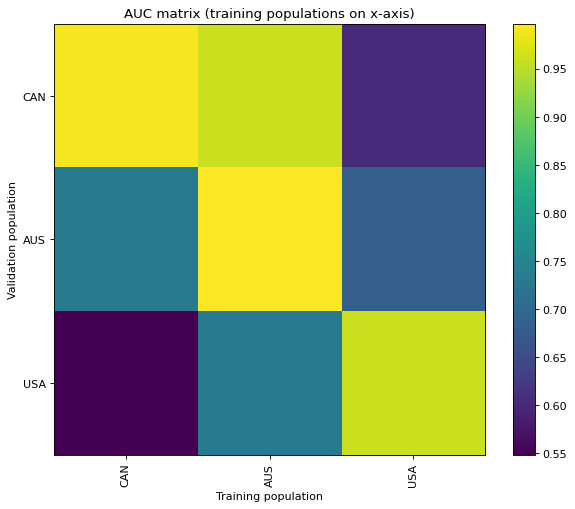

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_12 (Ba  (None, 10, 10, 3)         12        
 tchNormalization)                                               
                                                                 
 conv2d_8 (Conv2D)           (None, 6, 6, 16)          1216      
                                                                 
 batch_normalization_13 (Ba  (None, 6, 6, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_12 (Activation)  (None, 6, 6, 16)          0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 2, 16)          6416      
                                                                 
 batch_normalization_14 (Ba  (None, 2, 2, 16)         

In [16]:
allAuc = np.zeros((len(pops),len(pops)))
for jPop in range(len(pops)):
    np.random.seed(0)
    tf.random.set_seed(0)
    cnn = Sequential()
    cnn.add(BatchNormalization())
    cnn.add(Conv2D(filters=numberFilters,
             kernel_size=(filterSize,filterSize),
             strides=(1,1),
             padding='valid',
             data_format='channels_last'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))

    cnn.add(Conv2D(filters=numberFilters,
             kernel_size=(filterSize,filterSize),
             strides=(1,1),
             padding='valid',
             data_format='channels_last'))
    cnn.add(BatchNormalization())
    cnn.add(Activation('relu'))

    cnn.add(Flatten())
    cnn.add(Dense(1))
    cnn.add(Activation('sigmoid'))
    cnn.compile(loss='mean_squared_error', optimizer='sgd')
    summary = cnn.fit(x=X[pops[jPop]], y=Y[pops[jPop]], epochs=numberEpochs, batch_size=64, verbose=0)

    plt.figure(figsize=(9,7), dpi=80)
    plt.plot(summary.history['loss'][10:])
    #plt.plot(summary.history['val_loss'][10:])
    plt.title('Model loss on ' + pops[jPop])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    migErr = Y[pops[jPop]]>np.quantile(Y[pops[jPop]], thresholdQ)
    pred = cnn.predict(X[pops[jPop]])

    if pops[jPop] in ['CHE']:
        fig = plt.figure(figsize=(9,7), dpi=80)
        ax = fig.gca(projection='3d')
        x, y = np.meshgrid(ageBuckets[pops[jPop]], yearBuckets[pops[jPop]])
        ax.plot_surface(x, y, np.reshape(Y[pops[jPop]], (x.shape[0],x.shape[1])))
        ax.set_xlabel('Age bucket', fontsize=8)
        ax.set_ylabel('Year bucket', fontsize=8)
        ax.set_zlabel('$Y$', fontsize=8)
        ax.set_title(pops[jPop] + " output Y (arranged by age and year buckets)", fontsize=16)

        fig = plt.figure(figsize=(9,7), dpi=80)
        ax = fig.gca(projection='3d')
        x, y = np.meshgrid(ageBuckets[pops[jPop]], yearBuckets[pops[jPop]])
        ax.plot_surface(x, y, np.reshape(cnn.predict(X[pops[jPop]]), (x.shape[0],x.shape[1])))
        ax.set_xlabel('Age bucket', fontsize=8)
        ax.set_ylabel('Year bucket', fontsize=8)
        ax.set_zlabel('$P$', fontsize=8)
        ax.set_title(pops[jPop] + " prediction P (arranged by age and year buckets)", fontsize=16)

        plt.figure(figsize=(18,14), dpi=80)
        plt.imshow(np.reshape(Y[pops[jPop]], (len(Y[pops[jPop]])//len(ageBuckets[pops[jPop]]), len(ageBuckets[pops[jPop]]))), cmap='magma')
        plt.title(pops[jPop] + " output Y (arranged by age and year buckets)", fontsize=16)
        plt.xticks(np.arange(len(ageBuckets[pops[jPop]])), ageBuckets[pops[jPop]].astype(int))
        plt.yticks(np.arange(len(yearBuckets[pops[jPop]])), yearBuckets[pops[jPop]].astype(int))
        plt.xlabel('Age', fontsize=16)
        plt.ylabel('Year', fontsize=16)
        plt.colorbar()

        plt.figure(figsize=(18,14), dpi=80)
        plt.imshow(np.reshape(cnn.predict(X[pops[jPop]]), (len(Y[pops[jPop]])//len(ageBuckets[pops[jPop]]), len(ageBuckets[pops[jPop]]))), cmap='magma')
        plt.title(pops[jPop] + " prediction P (arranged by age and year buckets)", fontsize=16)
        plt.xticks(np.arange(len(ageBuckets[pops[jPop]])), ageBuckets[pops[jPop]].astype(int))
        plt.yticks(np.arange(len(yearBuckets[pops[jPop]])), yearBuckets[pops[jPop]].astype(int))
        plt.xlabel('Age', fontsize=16)
        plt.ylabel('Year', fontsize=16)
        plt.colorbar()

        plt.figure(figsize=(9,7), dpi=80)
        plt.plot(pred, Y[pops[jPop]][:,np.newaxis]-pred, 'b.')
        plt.plot(pred[migErr], Y[pops[jPop]][migErr,np.newaxis]-pred[migErr], 'r.')
        plt.title(pops[jPop] + " prediction P vs residuals Y-P")
        plt.xlabel('Prediction P')
        plt.ylabel('Residuals Y-P')

        plt.figure(figsize=(9,7), dpi=80)
        plt.plot(pred, Y[pops[jPop]][:,np.newaxis], 'b.')
        plt.plot(pred[migErr], Y[pops[jPop]][migErr,np.newaxis], 'r.')
        plt.title(pops[jPop] + " prediction P vs output Y")
        plt.xlabel('Prediction P')
        plt.ylabel('Output Y')

    for kPop in range(len(pops)):
        migErr = Y[pops[kPop]]>=np.quantile(Y[pops[kPop]], thresholdQ)
        pred = cnn.predict(X[pops[kPop]])
        probs = np.zeros(pred.size)
        probs[np.argsort(pred, axis=0)] = np.arange(pred.size)[:,np.newaxis]/pred.size
        allAuc[jPop,kPop] = roc_auc_score(migErr.astype(int), probs)

plt.figure(figsize=(9,7), dpi=80)
plt.imshow(allAuc, cmap='viridis')
plt.colorbar()
plt.title('AUC matrix (training populations on x-axis)')
plt.xlabel('Training population')
plt.ylabel('Validation population')
plt.xticks(np.arange(len(pops)), pops, rotation=90)
plt.yticks(np.arange(len(pops)), pops)
plt.show()
print(cnn.summary())

## 2. Detect clusters of similar migration/error structure based on AUC matrix

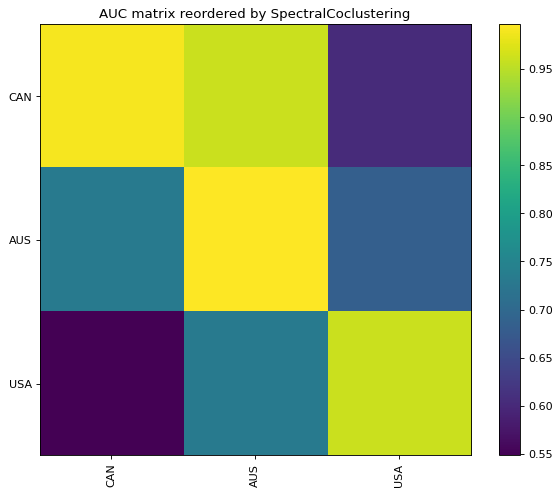

Cluster 0: ['CAN', 'AUS']
Cluster 1: ['USA']
['CAN', 'AUS']


In [19]:
import scipy as sp # Import scipy
model = SpectralCoclustering(n_clusters=2, random_state=0)
model.fit(allAuc)

idxSorted = np.argsort(model.row_labels_)
allAucSorted = allAuc[idxSorted,:]
allAucSorted = allAucSorted[:,idxSorted]

plt.figure(figsize=(9,7), dpi=80)
plt.imshow(allAucSorted, cmap='viridis')
plt.title('AUC matrix reordered by SpectralCoclustering')
plt.xticks(np.arange(len(pops)), [pops[k] for k in np.argsort(model.row_labels_)], rotation=90)
plt.yticks(np.arange(len(pops)), [pops[k] for k in np.argsort(model.row_labels_)])
plt.colorbar()
plt.show()

for j in range(max(model.row_labels_)+1):
    print('Cluster ' + str(j) + ': ' + str([pops[i] for i in np.nonzero(model.row_labels_==j)[0]]))

mode_value = sp.stats.mode(model.row_labels_)[0]
selectedPop = [pops[i] for i in np.nonzero(model.row_labels_==mode_value)[0]]
print(selectedPop) # Print the selected population to verify it's correct


## 3. Setup and train CNN on combined populations of largest cluster

2/2 [==============================] - 0s 9ms/step
AUC on test set of combined populations: 0.93
Train loss: 0.0022
Validation loss: 0.0027
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_15 (Ba  (None, 10, 10, 3)         12        
 tchNormalization)                                               
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 16)          448       
                                                                 
 batch_normalization_16 (Ba  (None, 8, 8, 16)          64        
 tchNormalization)                                               
                                                                 
 activation_15 (Activation)  (None, 8, 8, 16)          0         
                                                                 
 conv2d_11 (Conv2D)          (None, 6, 6, 32) 

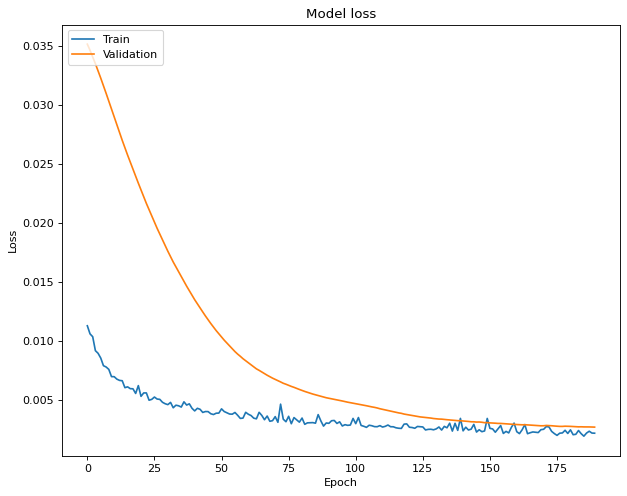

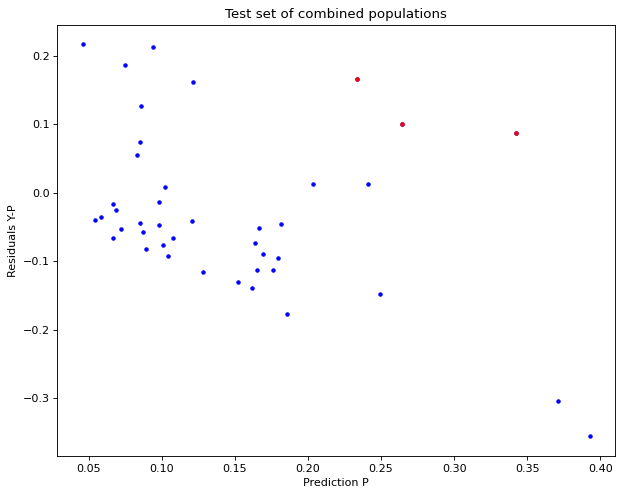

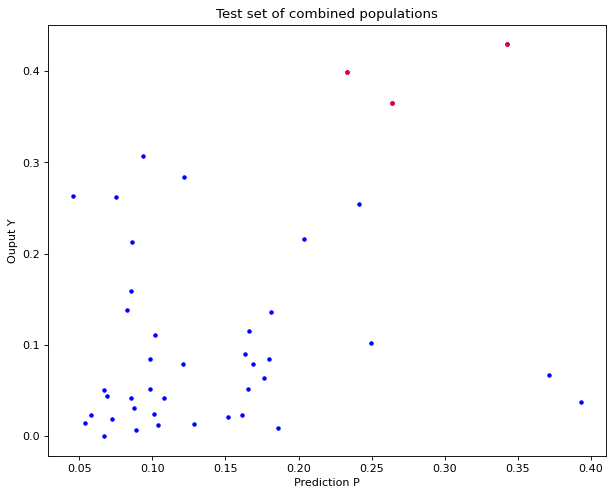

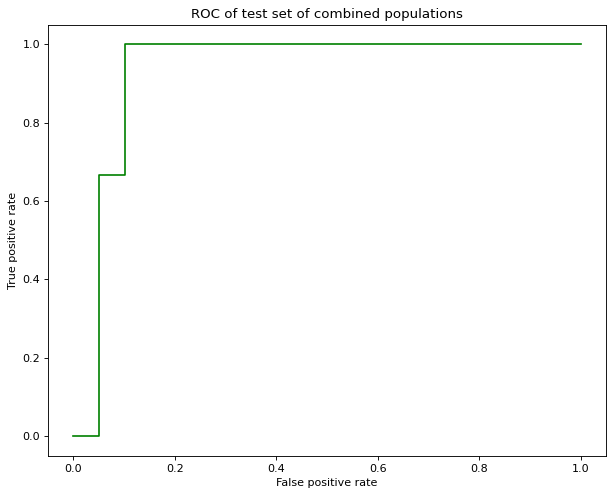

In [20]:
selectedX = dict((k, X[k]) for k in selectedPop)
selectedY = dict((k, Y[k]) for k in selectedPop)
allX = np.concatenate([k for k in selectedX.values()])
allY = np.concatenate([k for k in selectedY.values()])
np.random.seed(0)
tf.random.set_seed(0)
testIdx = np.random.uniform(0, 1, len(allY))<testRatio

cnn = Sequential()
cnn.add(BatchNormalization())

cnn.add(Conv2D(filters=numberFilters1,
             kernel_size=(filterSize1,filterSize1),
             strides=(1,1),
             padding='valid',
             data_format='channels_last'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))

cnn.add(Conv2D(filters=numberFilters2,
             kernel_size=(filterSize2,filterSize2),
             strides=(1,1),
             padding='valid',
             data_format='channels_last'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))

cnn.add(Conv2D(filters=numberFilters3,
             kernel_size=(filterSize3,filterSize3),
             strides=(1,1),
             padding='valid',
             data_format='channels_last'))
cnn.add(BatchNormalization())
cnn.add(Activation('relu'))

cnn.add(Flatten())
cnn.add(Dense(1))
cnn.add(Activation('sigmoid'))
cnn.compile(loss='mean_squared_error', optimizer='sgd')
summary = cnn.fit(x=allX[~testIdx], y=allY[~testIdx], epochs=numberEpochs//4,
                  validation_split=validationRatio/(1-testRatio), sample_weight=(0.2+allY[~testIdx])/1.2,
                  batch_size=64, verbose=0)

plt.figure(figsize=(9,7), dpi=80)
plt.plot(summary.history['loss'][10:])
plt.plot(summary.history['val_loss'][10:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

migErr = allY[testIdx]>=np.quantile(allY[testIdx], thresholdQ)
pred = cnn.predict(allX[testIdx])

plt.figure(figsize=(9,7), dpi=80)
plt.plot(pred, allY[testIdx,np.newaxis]-pred, 'b.')
plt.plot(pred[migErr], allY[testIdx][migErr,np.newaxis]-pred[migErr], 'r.')
plt.title('Test set of combined populations')
plt.xlabel('Prediction P')
plt.ylabel('Residuals Y-P')

plt.figure(figsize=(9,7), dpi=80)
plt.plot(pred, allY[testIdx,np.newaxis], 'b.')
plt.plot(pred[migErr], allY[testIdx][migErr,np.newaxis], 'r.')
plt.title('Test set of combined populations')
plt.xlabel('Prediction P')
plt.ylabel('Ouput Y')

probs = np.zeros(pred.size)
probs[np.argsort(pred, axis=0)] = np.arange(pred.size)[:,np.newaxis]/pred.size
auc = roc_auc_score(migErr.astype(int), probs)
x,y,_ = roc_curve(migErr.astype(int), probs)

plt.figure(figsize=(9,7), dpi=80)
plt.plot(x, y, 'g')
plt.title('ROC of test set of combined populations')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')

print('AUC on test set of combined populations: %.2f' % (auc))
print('Train loss: %.4f' % (np.mean(summary.history['loss'][-11:-1])))
print('Validation loss: %.4f' % (np.mean(summary.history['val_loss'][-11:-1])))
print(cnn.summary())

9/9 [==============================] - 0s 9ms/step


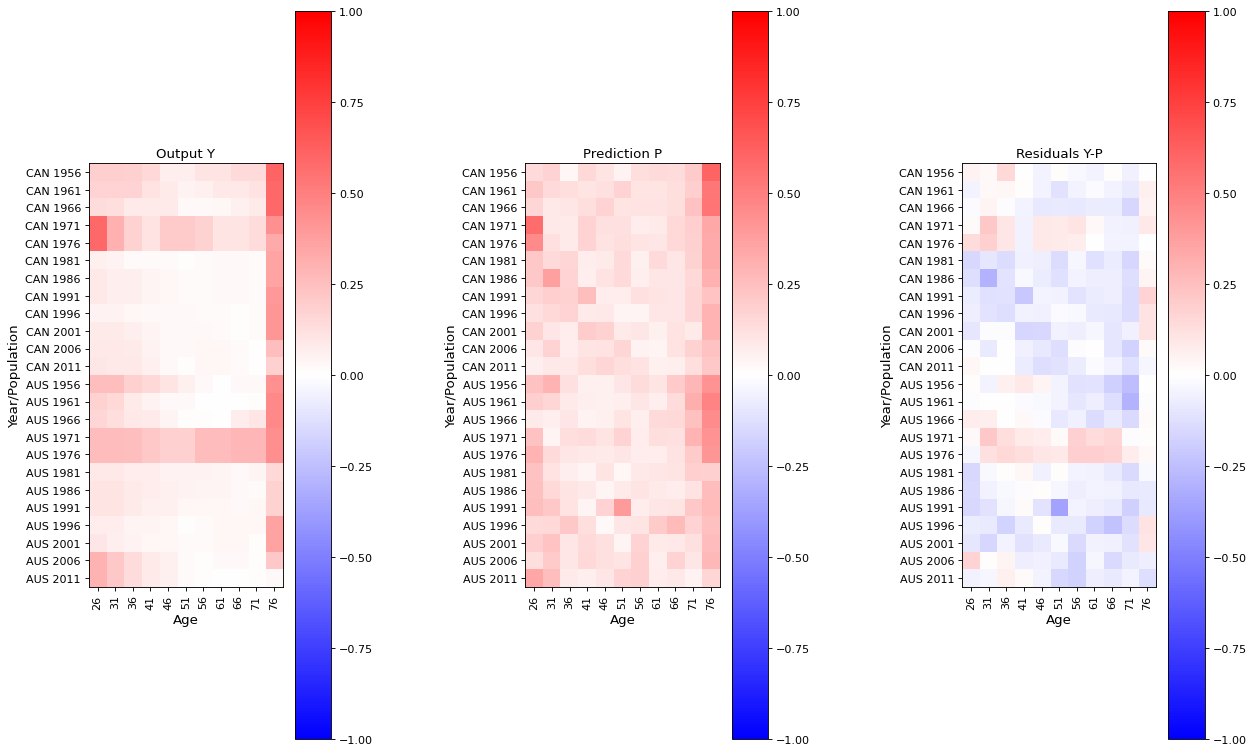

In [21]:
subfig, subax = plt.subplots(1, 3, sharex=True, figsize=(18,60), dpi=80)
subfig.subplots_adjust(hspace = .1, wspace=.8)
subax = subax.ravel()

ylabel = []
for pop in selectedPop:
    for j in range(len(yearBuckets[pop])):
        ylabel.append(pop + ' ' + str(yearBuckets[pop][j].astype(int)))

allP = cnn.predict(allX)

im = subax[0].imshow(np.reshape(allY, (len(allY)//len(ageBuckets[pop]), len(ageBuckets[pop]))), cmap='bwr', vmin=-1, vmax=1)
subax[0].set_title('Output Y', fontsize=12)
subax[0].set_xticks(np.arange(len(ageBuckets[pop])))
subax[0].set_xticklabels(ageBuckets[pop].astype(int), rotation=90)
subax[0].set_yticks(np.arange(len(ylabel)))
subax[0].set_yticklabels(ylabel)
subax[0].set_xlabel('Age', fontsize=12)
subax[0].set_ylabel('Year/Population', fontsize=12)
subfig.colorbar(im, ax=subax[0])

im = subax[1].imshow(np.reshape(allP, (len(allP)//len(ageBuckets[pop]), len(ageBuckets[pop]))), cmap='bwr', vmin=-1, vmax=1)
subax[1].set_title('Prediction P', fontsize=12)
subax[1].set_xticks(np.arange(len(ageBuckets[pop])))
subax[1].set_xticklabels(ageBuckets[pop].astype(int), rotation=90)
subax[1].set_yticks(np.arange(len(ylabel)))
subax[1].set_yticklabels(ylabel)
subax[1].set_xlabel('Age', fontsize=12)
subax[1].set_ylabel('Year/Population', fontsize=12)
subfig.colorbar(im, ax=subax[1])

im = subax[2].imshow(np.reshape(allY[:,np.newaxis]-allP, (len(allP)//len(ageBuckets[pop]), len(ageBuckets[pop]))), cmap='bwr', vmin=-1, vmax=1)
subax[2].set_title('Residuals Y-P', fontsize=12)
subax[2].set_xticks(np.arange(len(ageBuckets[pop])))
subax[2].set_xticklabels(ageBuckets[pop].astype(int), rotation=90)
subax[2].set_yticks(np.arange(len(ylabel)))
subax[2].set_yticklabels(ylabel)
subax[2].set_xlabel('Age', fontsize=12)
subax[2].set_ylabel('Year/Population', fontsize=12)
subfig.colorbar(im, ax=subax[2]);